# Characterizing MOA and performance of therapeutic agents for COVID-19

## Instructions
Since the severe acute respiratory syndrome - coronavirus 2 (SARS-COV-2) outbreak, repurposing of many existing therapeutic agents (TAs) previously designed for other virus infections are being put on trials for the coronavirus disease 2019 (COVID19) patients for possible immediate disease control and management. A quick understanding and bird-eye view on the MOA and performance of the TAs in experimental/clinical trial will be helpful in strategic life-saving and resource plannings.

Here, all abstracts available from the COVID-19 Open Research Dataset (CORD-19) and TAs targeting COVID-19 as of October 31, 2020 were retrieved from C3.ai databases. The author sought to rigorously summarize the performances of the TAs based on the literature abstracts currently available in the databases. 

```
Please read the README.md available in the current folder to install the necessary python packages necessary to run the notebook tutorials.
```

## Table of Content
The author tried to explain some steps along the sections - recommended to read from top to down before navigating around. 

1. Downloading abstracts from C3.ai (Optional)
2. Text Pre-processing (Optional)
3. Reload the preprocessed words
4. Create Dictionaries, subsampling, and getting batches
5. Validation of embedding vlues during model learning
6. SkipGram model
7. Retrieve the therapeutic assets from c3.ai data lake
8. Load the sentiment word lists freely available from the loughran_mcdonald study
9. First deep walking 
10. Second deep walking
11. Sparse relationship between TAs - revealing MOA and frequency of co-treatments
12. Sparse relations between the TAs and sentimental terms using simple correlation - revealing treatment performance
13. Author's final thoughts

In [ ]:
# # Check GPU specs (preferably more than 15gb)
# !nvidia-smi

Wed Nov 18 11:02:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Mounting google drive, if user is using Google Co-lab for this tutorial
from google.colab import drive
drive.mount('/gdrive')

# subject to changes according to the user's project diretory/path
%cd /gdrive/My Drive/Colab Notebooks/knowdisc/c3ai_drugs_moa_and_performance_evaluation

### Install/Import necessary packages
If user is using google colab, the following commands is sufficient. If user is using local machine, please refer to README.md for environment set up and package installation. A requirements.txt file is also provided in the project folder.

In [6]:
import sys
!{sys.executable} -m pip install pymed chart_studio wordcloud facets-overview
!{sys.executable} -m pip install seaborn scikit-learn statsmodels numba
!{sys.executable} -m pip install scanpy[leiden]

In [1]:
from __future__ import division

# Auto reload all .py file
%load_ext autoreload
%autoreload

from collections import Counter
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymed import PubMed
import gc
import re
from time import time
import torch
from tqdm import tqdm

import time

# C3.ai api and user-defined functions
import c3aidatalake
from utils import preprocess, create_lookup_tables, make_edge

# Visualization settings
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
from IPython.display import display # Allows the use of display() for DataFrames

# Pretty figure display for notebooks
%matplotlib inline

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [2]:
%cd Data

/Users/leehongkai/OneDrive/c3ai_drugs_moa_and_performance_evaluation/Data


### 1. Downloading abstracts 
All the abstract available in the biblioentry database from the c3ai Data Lake as of Oct 31, 2020 were already downloaded and saved as bibs_all.csv in the same project folder, under Data folder. There are also some manual data cleaning involved, i.e. removing non-relevant text or duplicates. To reproduce the same results seen in this tutorial, the user is advised to load the abstracts in table (i.e. Data/bibs_all.csv) directly from the [Google Drive download link](https://drive.google.com/drive/folders/1IVzzsTZM71T2y9eSJ-igxbUXPsebm9eg?usp=sharing) here.

Alternatively, the user may skip to the Step 3 directly to load the processed words for the downstream analyses by loading Data/

In [ ]:
# %%timeit
# Fetch metadata for the first two thousand (2000) BiblioEntry journal articles approved for commercial use
# Note that 2000 records are returned; the full dataset can be accessed using the get_all = True argument in fetch
bibs = c3aidatalake.fetch(
  "biblioentry",
{
  "spec": {
  }
}, get_all = True
)

# Sort them to get the most recent articles first
bibs["publishTime"] = pd.to_datetime(bibs["publishTime"])
bibs = bibs.sort_values("publishTime", ascending = False)

# # save the downloaded abstract to csv file
# bibs.to_csv('bibs_all.csv', sep=',')

In [ ]:
# Reloading the saved abstracts table.
bibs = pd.read_csv('bibs_all.csv', sep=',', index_col=0)

# cleaning the abstracts table
bibs = bibs[bibs['abstractText'].notna()] # dropping rows with nan values in abstractText column
bibs = bibs[bibs['doi'].notna()] # dropping rows with nan values in doi column

# removing duplicated abstracts or non-relevant/non-informative abstract. 
# This step requires careful checking by the user while removing the duplicated/non-informative abstracts)
# (only applicable to data downloaded as of Oct 31, 2020)
null_abstract_contents_1 = bibs.abstractText.value_counts()[bibs.abstractText.value_counts()>3].keys()
bibs = bibs[~bibs['abstractText'].isin(list(null_abstract_contents_1))]
null_abstract_contents_2 = bibs.abstractText.value_counts()[bibs.abstractText.value_counts()==3].keys()[1:]
bibs = bibs[~bibs['abstractText'].isin(list(null_abstract_contents_2))]

bibs.abstractText.value_counts()[bibs.abstractText.value_counts()==2].keys()
# print(null_abstract_contents_2)

bibs = bibs.drop_duplicates(subset=['abstractText'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (14,16) have mixed types.Specify dtype option on import or set low_memory=False.



### 2. Text Pre-processing 
Here, the preprocess function from the utils.py does a few things:

1. It converts any punctuation into tokens, so a period is changed to `<PERIOD>`.
2. It removes all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
    
It returns a list of words in the text.  
    
The user may skip to the Steps 1 and 2 directly to load the processed words directly (i.e. Data/words_covid_c3ai.npy) at the Step 3 for the downstream analyses.

In [ ]:
# %%timeit
appended_text = ''

for text in tqdm(bibs.abstractText, desc='Appending words...', 
                                unit=' documents', position=0):
    
    # get list of words
    if text:
        appended_text += '\n' + text

words = preprocess(appended_text)


Trimming words...: 100%|██████████| 33502310/33502310 [00:14<00:00, 2240409.88 words/s]


In [ ]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 32926795
Unique words: 80290


In [ ]:
# save numpy array as npy file
from numpy import save

# save to npy file
save('words_covid_c3ai.npy', np.array(words))


### 3. Reload the preprocessed words

In [ ]:
# load the npy file of the pre-processedwords list 
from numpy import load

# load npy words file
words = list(load('words_covid_c3ai.npy'))

In [ ]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 32926795
Unique words: 80290


Defining corpuses to be used in this tutorial later

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('words')
    
# defining corpus for stop words
stop_words = set(nltk.corpus.stopwords.words('english')) 

# defining corpus for punctions
droplist_punctuation = ['<PERIOD>', '<COMMA>', '<QUOTATION_MARK>', '<SEMICOLON>', '<EXCLAMATION_MARK>', '<QUESTION_MARK>', 
 '<LEFT_PAREN>', '<RIGHT_PAREN>', '<HYPHENS>', '<QUESTION_MARK>', '<NEW_LINE>', '<COLON>']

# defining corpus for english_words
english_words = set(nltk.corpus.words.words())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


### 4. Create Dictionaries, subsampling, and getting batches
Next, create two dictionaries to convert words to integers and back again (integers to words). 

The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. Once we have our dictionaries, the words are converted to integers and stored in the list int_words.

In [ ]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[21, 317, 23, 51, 100, 25, 950, 270, 5, 91, 686, 4, 2960, 184, 0, 5, 85, 686, 184, 1, 51, 100, 25, 78, 10, 11881, 1038, 51, 598, 124]


#### Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we will remove some of the noise from the data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$


In [ ]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}

# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[11881, 598, 4337, 2435, 1201, 105, 1938, 248, 516, 105, 2595, 5138, 7057, 408, 6549, 634, 5061, 1172, 485, 1710, 1644, 10329, 3, 4409, 5315, 3975, 1505, 4858, 2597, 35377]


#### Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

Say, we have an input and we're interested in the idx=2 token, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

For `R=2`, `get_target` should return a list of four values:
```
[5233, 58, 10571, 27349]
```

In [ ]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [ ]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

---
### 5. Validation of embedding vlues during model learning

We use cosine similarity on the embedding values to check out our model as it learns. We choose few common words and few uncommon words and print out the closest words to them using the cosine similarity as the model learns: 

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


In [ ]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    # valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.array([vocab_to_int['interferon'], vocab_to_int['severe'], vocab_to_int['drug'], vocab_to_int['gender']])
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

### 6. SkipGram model

Define and train the SkipGram model. 
> Define an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) with **embedding_dim of 300** and a final, softmax output layer.


In [ ]:
import torch
from torch import nn
import torch.optim as optim

class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps
    
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 10000
steps = 0
epochs = 20

#### Train the model
A copy of train model is already saved and available from the folder. To skip the lengthy training time, you can load the saved model directly in the following cells.

In [ ]:
# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 100):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:     
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...epoch {}...".format(e))

In [ ]:
# Save model
# torch.save(model.state_dict(), 'model_trained_coronavirus_20epoch.pt')

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_trained_coronavirus_20epoch.pt'))

<All keys matched successfully>

#### Visualizing the word vectors
T-SNE is used to visualize how the high-dimensional word vectors cluster together. Here, we chose only the first 500 words to see how the quality of embedding values 

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

viz_words = 500
pca = PCA()
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

30

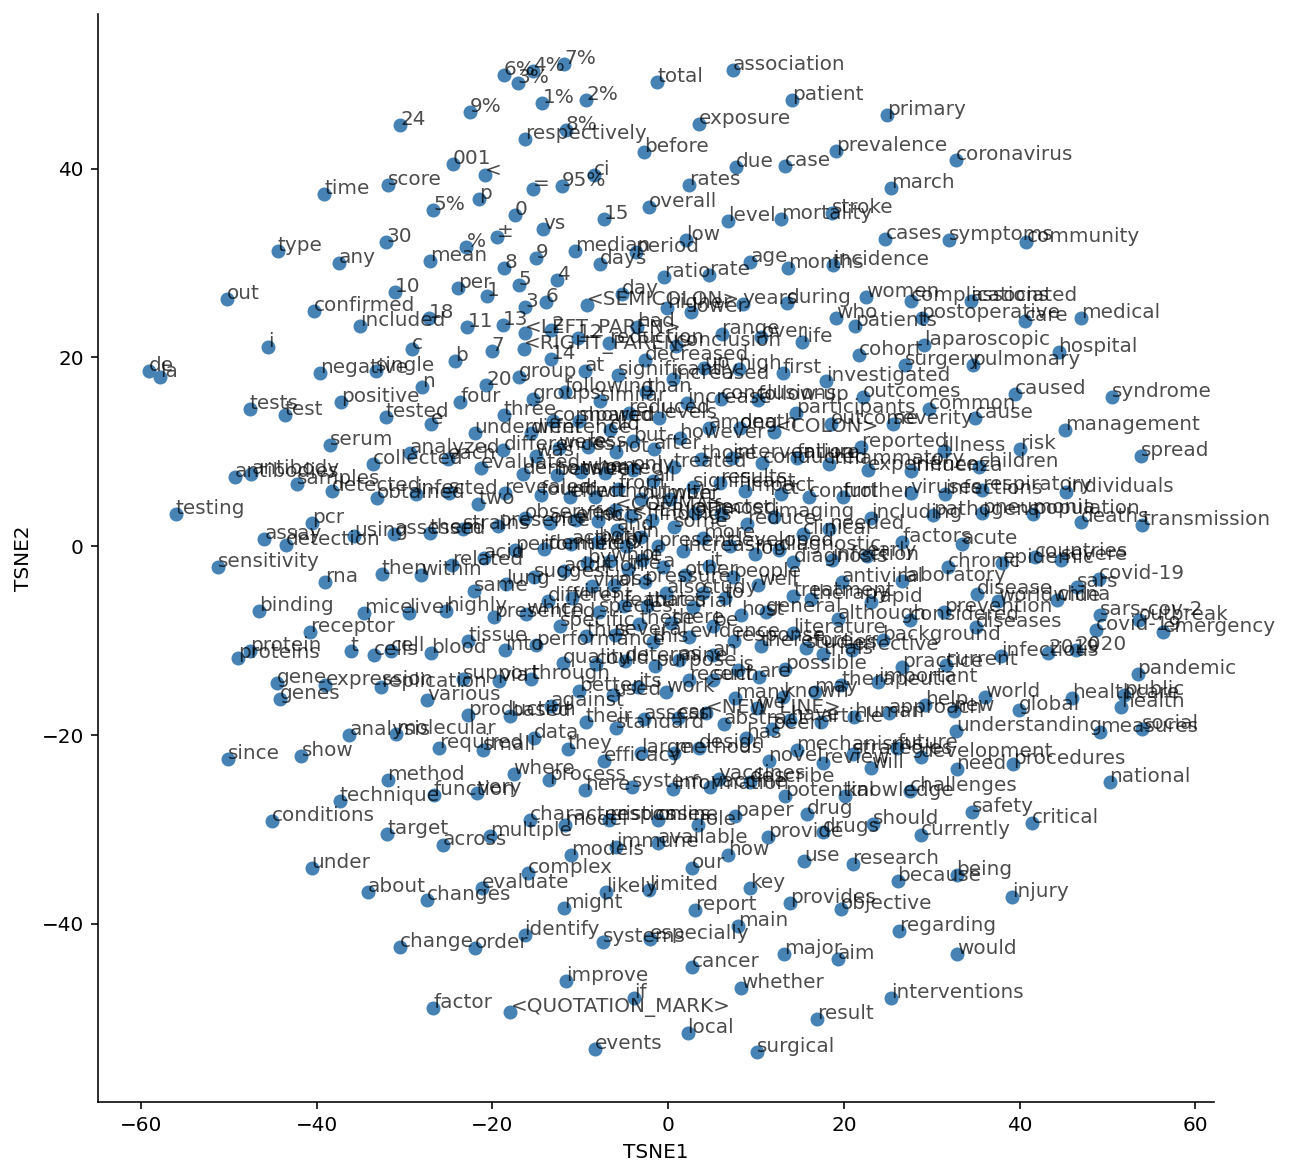

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

# settings
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')

# plt.savefig('figures/tsne_embeddings_20epoch.pdf')  

embeddings = 0
embed_tsne = 0
gc.collect()

### 7. Retrieve the therapeutic assets from c3.ai data lake
Only the Antibodies and Antivirals currently on trials to target COVID-19 patients. The tokenized word list were prepared manually from the assets descriptions.

In [ ]:
# Join data from TherapeuticAsset and ExternalLink (productType, description, origin, and URL links)
assets = c3aidatalake.fetch(
  "therapeuticasset",
  {
      "spec" : {
          "include" : "productType, description, origin, therapyType, target",
            "filter": "therapyType == 'Antibodies' || therapyType == 'Antivirals' && target == 'COVID-19'"
      }
  }
)

assets = assets.drop_duplicates(subset=['description'])

for desc in assets.description:
    print(desc)
    

In [ ]:
# Manually define the word list of therapeutic agents available
c3aidatalake_assets = ['hyperimmune', 'H-IG', 'REGN3048-3051', 'CT-P59', 'COVI-SHIELD', 'VIR-7831', 'VIR-7832', 
'Immunoglobulin', 'Avastin', 'bevacizumab', 'Thymosin', 'Opdivo', 'nivolumab', 'leronlimab', 
'AiRuiKa', 'camrelizumab', 'Kevzara', 'sarilumab', 'Actemra', 'tocilizumab', 'Gimsilumab', 
'anti-granulocyte-macrophage', 'JM2', 'TJ003234', 'lenzilumab', 'Sylvant', 'siltuximab', 'Soliris', 'eculizumab',
'Ilaris', 'canakinumab', 'Gamifant','emapalumab', 'meplazumab', 'anti-CD147', 'LY3127804','anti-Angiopoietin', 'Ang2',
'Ultomiris', 'ravulizumab-cwvz', 'IFX-1', 'anti-C5a', 'otilimab','TLR4', 'CXC10', 'COVID-EIG', 'SAB-185', 'rCIG', 
'IC14', 'anti-CD14','MEDI3506', 'Octagam', 'JS016', 'sdAbs','Favilavir','Favipiravir','T-705','Avigan', 
'Kaletra','Aluvia', 'lopinavir', 'ritonavir', 'Kaletra/Aluvia', 'lopinavir/ritonavir', 'remdesivir', 'Prezcobix', 
 'darunavir', 'cobicistat', 'CYP3A','galidesivir', 'Ganovo','danoprevir', 'ritonavir',
'ASC09', 'Truvada', 'emtricitabine', 'tenofovir', 'Arbidol','umifenovir', 'Vicromax',
'ISR-50', 'oseltamivir', 'EIDD-2801', 'Virazole','ribavirin','Levovir','clevudine',
'AB001','BTL-tml','DAS181', 'emetine', 'AT-527', 'PLX', 'Mesenchymal', 'admscs', 'msc', 'Ryoncil', 
'remestemcel-L', 'MultiStem', 'Allogeneic', 'nk', 'CYNK-001', 'CAP-1002', 'haNK', 'Astrostem-V', 'CART', 
'(CAR)/T']

### 8. Load the sentiment word lists freely available from the loughran_mcdonald study

Word lists can be downloaded from:
https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists


In [ ]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv('loughran_mcdonald_master_dic_2016.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words
sentiment_df['word'] = sentiment_df['word'].str.lower()

# Only retrieve positive, negative and uncertainty words 
sentiment_terms = list(sentiment_df[(sentiment_df.negative == True) |
                      (sentiment_df.positive == True) |
                      (sentiment_df.uncertainty == True)].word.values)

# Defining sentiment-specific terms only for later use
sentiment_terms_positive = list(sentiment_df[(sentiment_df.positive == True)].word.values)
sentiment_terms_negative = list(sentiment_df[(sentiment_df.negative == True)].word.values)
sentiment_terms_uncertainty = list(sentiment_df[(sentiment_df.uncertainty == True)].word.values)

# housekeeping - clear out memory
sentiment_df = 0
gc.collect()

22

In [ ]:
# appending the user-added sentiments to the loughran_mcdonald sentimental wordlist                         
performance_terms = ['intolerance', 'promising',  'side-effect'] + sentiment_terms
performance_terms = list(set([x.lower() for x in performance_terms]))
performance_terms = list(set(performance_terms) & set(words))

# appending the user-added theraupeutic agents to the list avaiable from the C3.ai therapeuticasset db                  
user_input_assets = ['anti-tnf', 'atazanavir',  'infliximab',  'arb', 'acei', 'baricitinib', 'opaganib', 
                        'ruxolitinib', 'Fostamatinib', 'Tirofiban', 'Clopidogrel', 'Acetylsalicylic',
                        'Fondaparinux', 'Favipiravir', 'Remdesivir', 'interferon-α', 'Ivermectin', 
                        'Lopinavir/Ritonavir', 'Hydroxychloroquine', 'Umifenovir', 'rhACE2', 'IVIG', 
                         'anti-C5a', 'IL-6', 'sarilumab',  'interferon-β', 'dexamethasone', 'Ivermectin',
                       'glucocorticoids', 'corticosteroids', 'convalescent', 'Anakinra', 'Leflunomide'
                       'Thalidomide']

all_assets = c3aidatalake_assets + user_input_assets
all_assets = list(set([x.lower() for x in all_assets]))
all_assets = list(set(all_assets) & set(words))

# combine therapeutic assets and performance terms
study_scientific_terms = all_assets + performance_terms 

# words = 0
gc.collect()

# First deep walking function
def cosine_similarity_predict(embedding, study_terms, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # get vocab int 
    ls_word_int = np.array([vocab_to_int[w] for w in study_terms])
    ls_word_int = torch.LongTensor(ls_word_int).to(device)
    
    int_vectors = embedding(ls_word_int)
    similarities = torch.mm(int_vectors, embed_vectors.t())/magnitudes
        
    return ls_word_int, similarities

# getting examples and similarities      
ls_word_int, similarities = cosine_similarity_predict(model.embed, study_scientific_terms, device=device)
_, closest_idxs = similarities.topk(10) # topk highest similarities

ls_word_int, closest_idxs = ls_word_int.to('cpu'), closest_idxs.to('cpu')
clade_words_int = np.empty((0, 10), int)

for ii, valid_idx in enumerate(ls_word_int):
    closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
#     print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
    clade_words_int = np.append(clade_words_int, np.array(closest_idxs[ii]))
    
train_words = 0
gc.collect()

0

In [ ]:
# remove the english words from the neighbor 
clade_words_int = np.array([word_int for word_int in clade_words_int if int_to_vocab[word_int] not in english_words or not int_to_vocab[word_int].isalpha()])
clade_words_int = np.array([x for x in clade_words_int if (x not in stop_words)])
clade_words_int = np.array([word_int for word_int in clade_words_int if (int_to_vocab[word_int] not in droplist_punctuation)])

# housekeeping - clear out memory
# english_words = 0 
gc.collect()

0

In [ ]:
# append the existing study wordlist to the neighbours
clade_words_int = np.array(list(set(np.append(np.array([vocab_to_int[w] for w in study_scientific_terms]),
                                              clade_words_int))))
len(clade_words_int)

5050

### 10. Second deep walking

Finding the 60 second level nearest neighbour words - The second level nearest neighbour words were found using the first 60 nearest neighbour retrived using the therapeutic agents and the sentimental terms + the existing therapeutic agents and the sentimental terms


In [ ]:
def cosine_similarity_predict_clade(embedding, clade_words_int, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
        
    # get vocab int 
    ls_word_int = np.array(clade_words_int)
    ls_word_int = torch.LongTensor(ls_word_int).to(device)
    
    int_vectors = embedding(ls_word_int)
    similarities = torch.mm(int_vectors, embed_vectors.t())/magnitudes
        
    return ls_word_int, similarities

In [ ]:
# getting  and similarities      
ls_word_int, similarities = cosine_similarity_predict_clade(model.embed, clade_words_int, device=device)
n_closest = 100
_, closest_idxs = similarities.topk(n_closest) # topk highest similarities
ls_word_int, closest_idxs = ls_word_int.to('cpu'), closest_idxs.to('cpu')

len(np.unique(closest_idxs))

47324

### 11. Sparse relationship between TAs - revealing MOA and frequency of co-treatments
Here, we are particularly interested in the relationship between the TAs. By using appearance of closest words obtained from the deep walkings, we can see that the TAs can be linked in terms of mechanism of action (MOA) of the TAs and frequency of co-treatments of TAs- shown with the edges presence between TAs (especially the antivirals).


In [ ]:
# create a dataframe to build network graph between TAs
df_network = pd.DataFrame(columns=['target', 'closest'])

for ii, word_idx in tqdm(enumerate(ls_word_int), 
                         desc='Processing words...', 
                         unit=' words', position=0):
  
    closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
    closest_words = [w for w in closest_words if (w not in stop_words)]
    closest_words = [w for w in closest_words if (w not in droplist_punctuation)]
    df_network_tmp = pd.DataFrame(columns=['target', 'closest'])
    df_network_tmp['target'] = [int_to_vocab[word_idx.item()] for item in range(1, len(closest_words) + 1)]
    df_network_tmp['closest'] = closest_words
    df_network = pd.concat([df_network, df_network_tmp], axis=0)

Processing words...: 5050 words [00:47, 106.89 words/s]


In [ ]:
# filter for only TA terms involved in our study
df_network = df_network[df_network['target'].isin(all_assets)]
df_network = df_network[df_network['closest'].isin(all_assets)]
df_network.head()

,target,closest
25,nivolumab,ribavirin
26,nivolumab,tenofovir
27,nivolumab,bevacizumab
34,nivolumab,dexamethasone
1,acei,arb


In [ ]:
# prepare df for network graph
df_network['combo_list'] = df_network['target'].map(str) + ',' + df_network['closest'].map(str)
df_network['combo_list'] = df_network['combo_list'].str.split(',', n = 1, expand = False) 
df_network['combo_list'] = df_network.combo_list.apply(lambda x: sorted(x))
df_network['combo_list'] = [','.join(map(str, l)) for l in df_network['combo_list']]

df_network_consolidated = pd.DataFrame(df_network['combo_list'].value_counts()).reset_index()
df_network_consolidated.columns = ['pairs', 'interaction_counts']
df_network_consolidated[['Source', 'Target']] = df_network_consolidated['pairs'].str.split(',', n = 1, expand = True) 
df_network_consolidated = df_network_consolidated.drop(columns=['pairs'])
df_network_consolidated = df_network_consolidated[['Source', 'Target', 'interaction_counts']]

# housekeeping - clear out memory
df_network = 0
gc.collect()

12

In [ ]:
# prepare word appearance dictionary for the network graph
word_appearance = df_network_consolidated['Source'].append(df_network_consolidated['Target']).value_counts()
word_appearance = word_appearance.to_dict()

In [ ]:
import plotly.offline as py
import plotly.graph_objects as go
import networkx as nx
import re
# Network figure inspired by https://github.com/rweng18/midsummer_network/blob/master/midsummer_graph.ipynb

midsummer = nx.Graph()

# Add node for each character
for char in word_appearance.keys():
    if word_appearance[char] > 0:
        midsummer.add_node(char, size = word_appearance[char])

# For each co-appearance between two characters, add an edge
for char in df_network_consolidated['Source']:
    for co_char in df_network_consolidated[df_network_consolidated.Source == char]['Target']:
    
        # Only add edge if the count is available
        midsummer.add_edge(char, co_char, weight = df_network_consolidated[(df_network_consolidated.Source == char) &
                                                                           (df_network_consolidated.Target == co_char)]['interaction_counts'].values[0])


In [ ]:
# Get positions for the nodes in G
pos_ = nx.kamada_kawai_layout(midsummer)

# For each edge, make an edge_trace, append to list
edge_trace = []
for edge in midsummer.edges():
    
    if midsummer.edges()[edge]['weight'] > 0:
        char_1 = edge[0]
        char_2 = edge[1]

        x0, y0 = pos_[char_1]
        x1, y1 = pos_[char_2]

        text   = char_1 + '--' + char_2 + ': ' + str(midsummer.edges()[edge]['weight'])
        
        trace  = make_edge([x0, x1, None], [y0, y1, None], text,
                           0.3*midsummer.edges()[edge]['weight']**1.75)

        edge_trace.append(trace)

In [ ]:
# Make a node trace
node_trace = go.Scatter(x         = [],
                        y         = [],
                        text      = [],
                        textposition = "middle center",
                        textfont_size = 10,
                        mode      = 'markers+text',
                        hoverinfo = 'none',
                        marker    = dict(color = [],
                                         size  = [],
                                         line  = None))
# For each node in midsummer, get the position and size and add to the node_trace
for node in midsummer.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple(['cornflowerblue'])
    node_trace['marker']['size'] += tuple([1.5*midsummer.nodes()[node]['size']])
    node_trace['text'] += tuple(['<b>' + node + '</b>'])


# layout
layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# figure
fig = go.Figure(layout = layout)

for trace in edge_trace:
    fig.add_trace(trace)

fig.add_trace(node_trace)

fig.update_layout(showlegend = False,
                      autosize=False,
                      width=1200,
                      height=1000)

fig.update_layout(
)

fig.update_xaxes(showticklabels = False)
fig.update_yaxes(showticklabels = False)

fig.show()
py.plot(fig, filename='figures/covid_c3ai.html')

'figures/covid_c3ai.html'

### 12. Sparse relations between the TAs and sentimental terms using simple correlation - revealing treatment performance
We are particularly interested in the relationship between the TAs and the positive, negative, and uncertainty sentiments. Here, by using simple correlation, we try to look for the relationship between TAs and sentimental words.

In [ ]:
# create a dataframe to collect similar words from second deep walk 
df_similarity = pd.DataFrame(0, columns = [int_to_vocab[i] for i in np.unique(closest_idxs)], index=[int_to_vocab[i] for i in clade_words_int])

for ii, word_idx in tqdm(enumerate(ls_word_int), 
                         desc='Processing words...', 
                         unit=' words', position=0):
    closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
    closest_words = [w for w in closest_words if (w not in stop_words)]
    closest_words = [w for w in closest_words if (w not in droplist_punctuation)]
#     print(int_to_vocab[word_idx.item()] + " | " + ', '.join(closest_words))
    
    for closest_w in closest_words:
        df_similarity.loc[int_to_vocab[word_idx.item()], closest_w] += 1

# housekeeping - clear out memory
clade_words_int = 0
gc.collect()

# df_similarity.to_csv('df_similarity_20epoch.csv')

Processing words...: 5050 words [03:35, 23.40 words/s]


0

In [ ]:
# Perform correlations between the study terms
df_corr = df_similarity.T[study_scientific_terms].corr()

# housekeeping - clear out memory
df_similarity = 0
gc.collect()

152828

Here, we can check the correlations of some TAs and some performance-related sentimental keywords

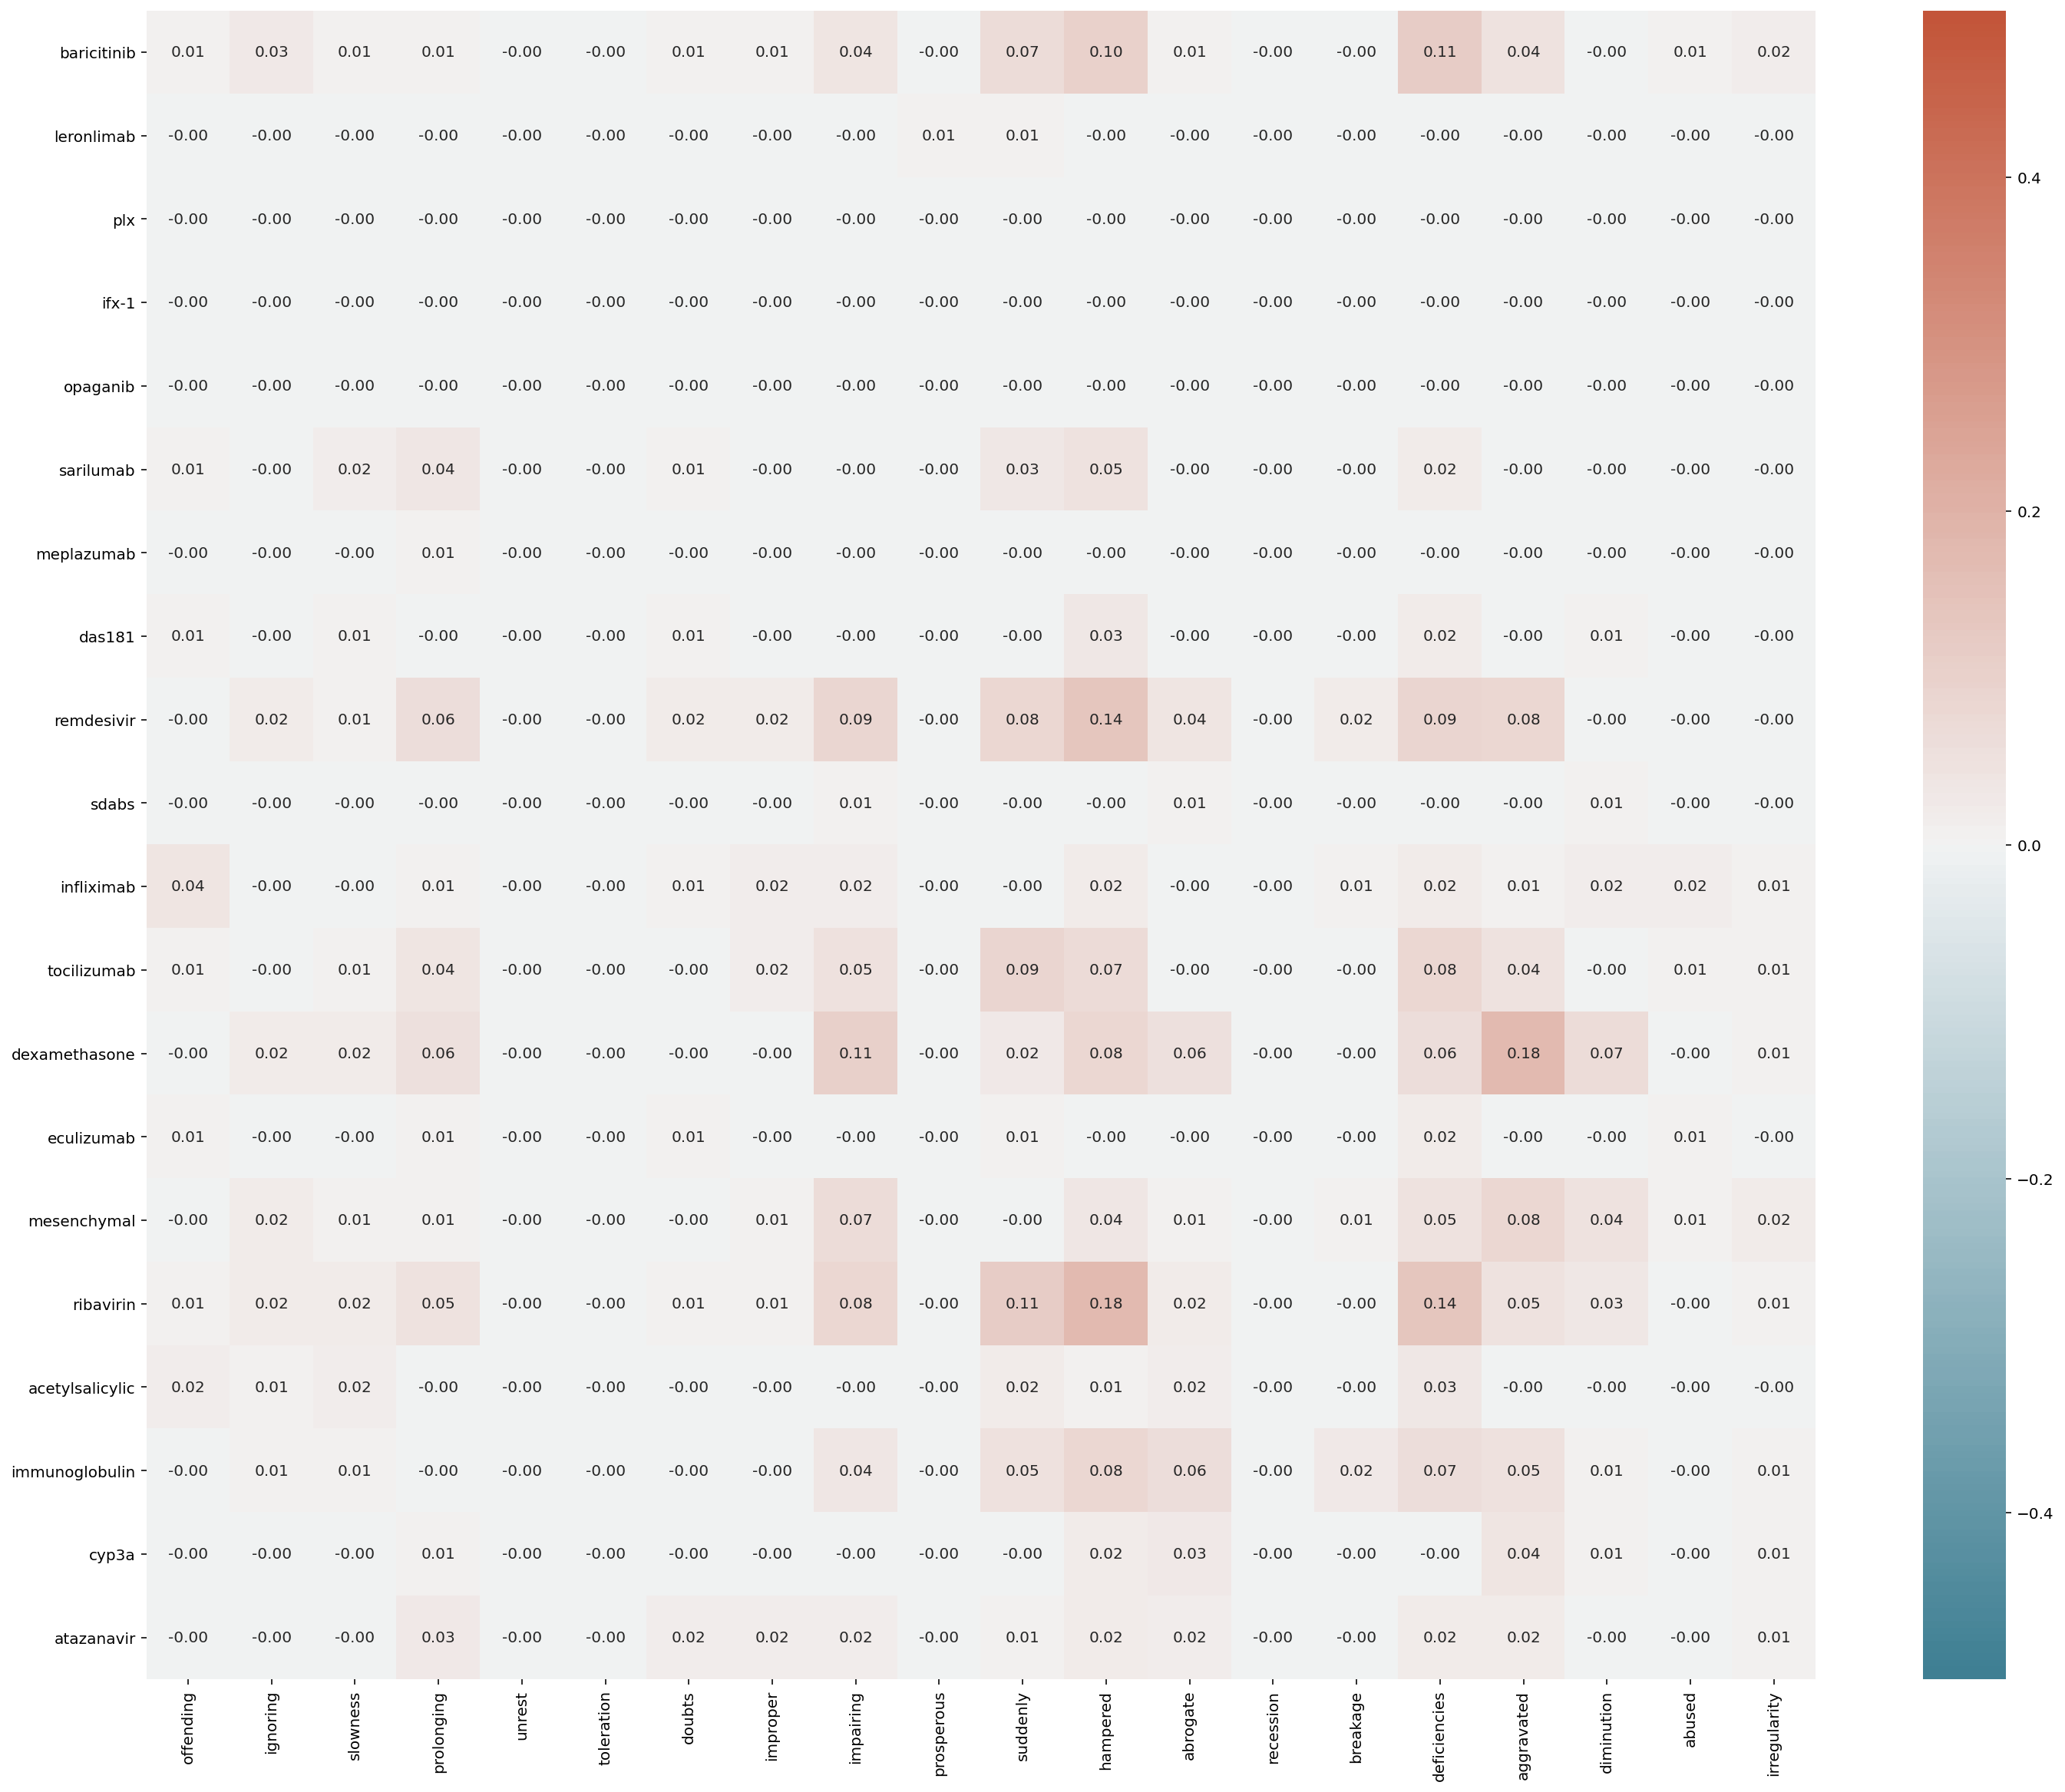

In [ ]:
import seaborn as sns

# get correlation df that only included study terms
df_corr_studyterm = df_corr.loc[study_scientific_terms, study_scientific_terms]

# define figure and size
plt.figure(figsize=(25,20))

# plot the heatmap for correlation matrix
ax = sns.heatmap(df_corr_studyterm.loc[all_assets[:20], performance_terms[:20]], 
                vmin=-0.5, vmax=0.5, center=0,
                cmap=sns.diverging_palette(220, 20, n=200),
                square=True, annot=True, fmt='.2f')

# figure settings
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0);

In [ ]:
# finalize the correlation matrix that with all TAs as row/subjects and performance terms as columns/features
df_corr_performance = df_corr_studyterm.loc[all_assets, performance_terms]
# df_corr_performance.to_csv('df_corr_performance_20epoch.csv', sep=',')

### Characterising the TAs by the sentimental words using clustering and dimensional reductions

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning:

invalid value encountered in log



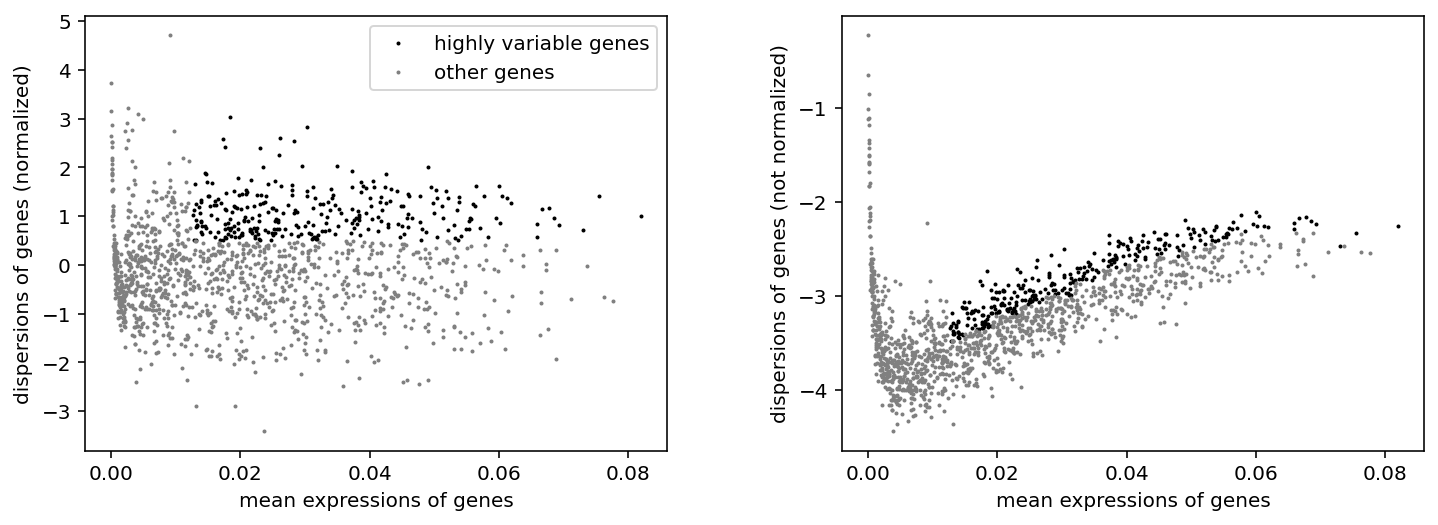

AnnData object with n_obs × n_vars = 71 × 1796
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [ ]:
import scanpy as sc

# set result filename
results_file = 'df_corr_performance_20epoch.h5ad'

# Loading pandas dataframe as anndata 
adata = sc.AnnData(df_corr_performance)

# Set the .raw attribute of AnnData object to raw performance value for later use in differential 
# testing and visualizations of features expression. This simply freezes the state of 
# the AnnData object.
adata.raw = adata

# Identify highly-variable features.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# save the results
# adata.write(results_file)
adata

In [ ]:
# read previously save result file
adata = sc.read(results_file)


In [ ]:
# include only those sentimental terms successfully "reached" by the deep walking steps
sentiment_terms_positive_used = [term for term in adata.var_names if term in sentiment_terms_positive + ['promising']]
sentiment_terms_negative_used = [term for term in adata.var_names if term in sentiment_terms_negative + ['intolerance', 'side-effect']] #
sentiment_terms_uncertainty_used = [term for term in adata.var_names if term in sentiment_terms_uncertainty]

# calculate the aggregate (median) scores for each set of sentiments
positive_scores = adata.to_df()[sentiment_terms_positive_used].median(axis=1)
negative_scores = adata.to_df()[sentiment_terms_negative_used].median(axis=1)
uncertainty_scores = adata.to_df()[sentiment_terms_uncertainty_used].median(axis=1)

In [ ]:
# add the aggregates as a separate observations to the therapeutic agents (ie not as a new features to the matrix)
adata.obs['positive_scores'] = positive_scores.values
adata.obs['negative_scores'] = negative_scores.values
adata.obs['uncertainty_scores'] = uncertainty_scores.values

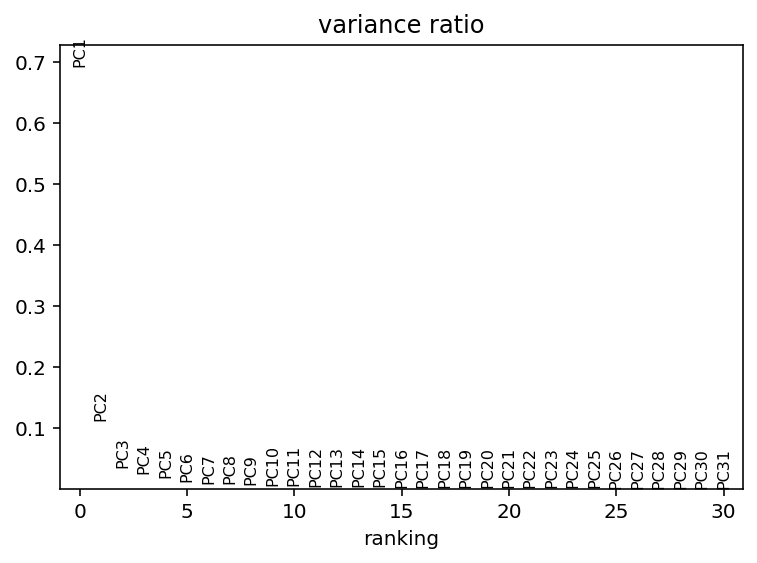

In [ ]:
# Principle component analysis on the sentimental matrix 
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, n_pcs=30)

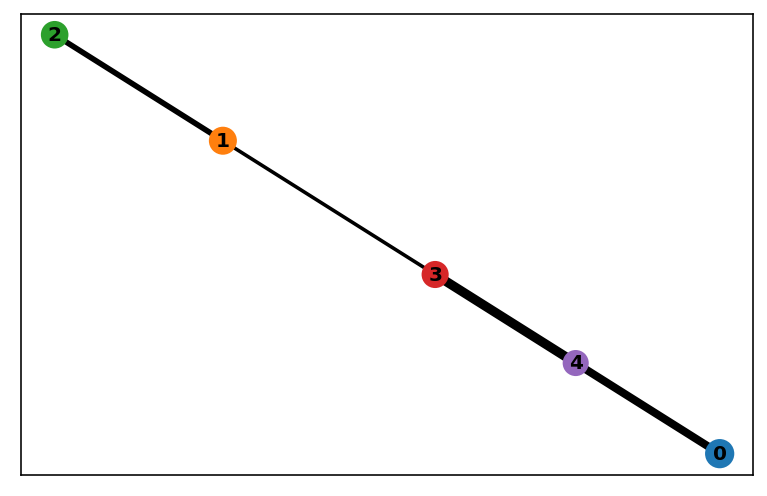

In [ ]:
# Computing the neighborhood graph - We compute the neighborhood graph of companies using the PCA representation of the data matrix. 
# This will give rise to distances and connectivities between TAs. Here, we consider 10 nearest neighbors with 3 PCs derived from the PCA.
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=2);
sc.tl.leiden(adata)

# rcParams['figure.figsize'] = 4,4
sc.tl.paga(adata)
sc.pl.paga(adata, plot=True)

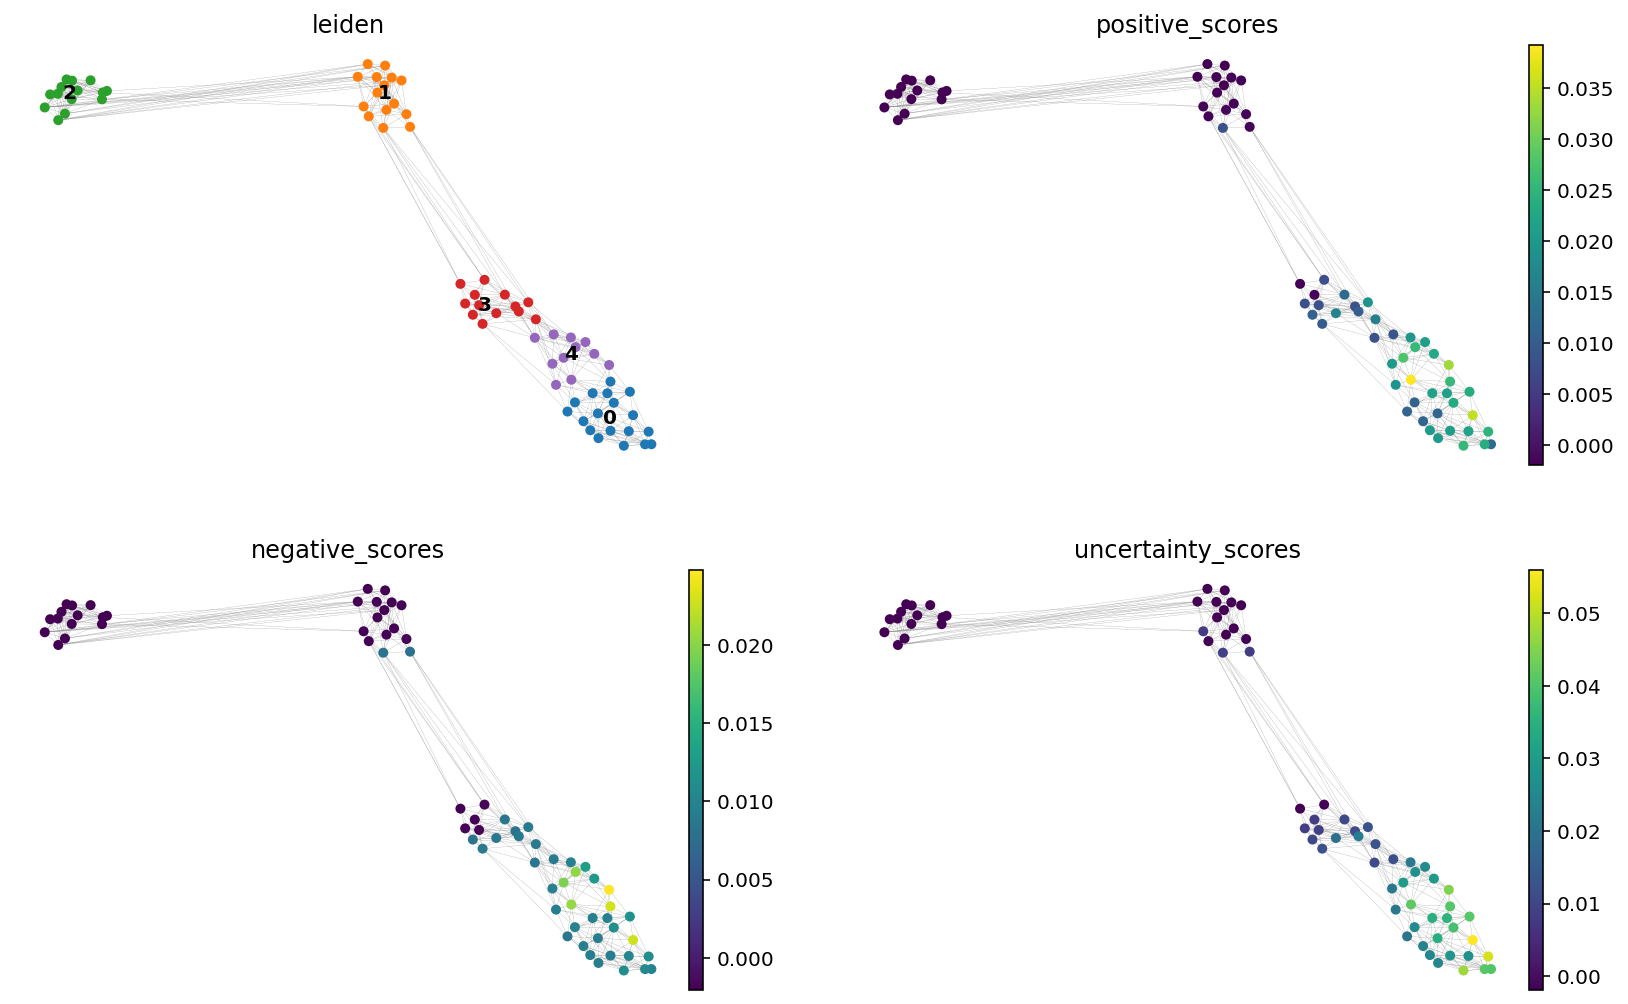

In [ ]:
# rcParams['figure.figsize'] = 8,8
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden', 'positive_scores', 'negative_scores', 'uncertainty_scores'], 
           legend_loc='on data', frameon=False, ncols=2, s=100, edges=True)#, save='UMAP_feature_plots_20epoch.pdf')

Text(0, 0.5, 'UMAP2')

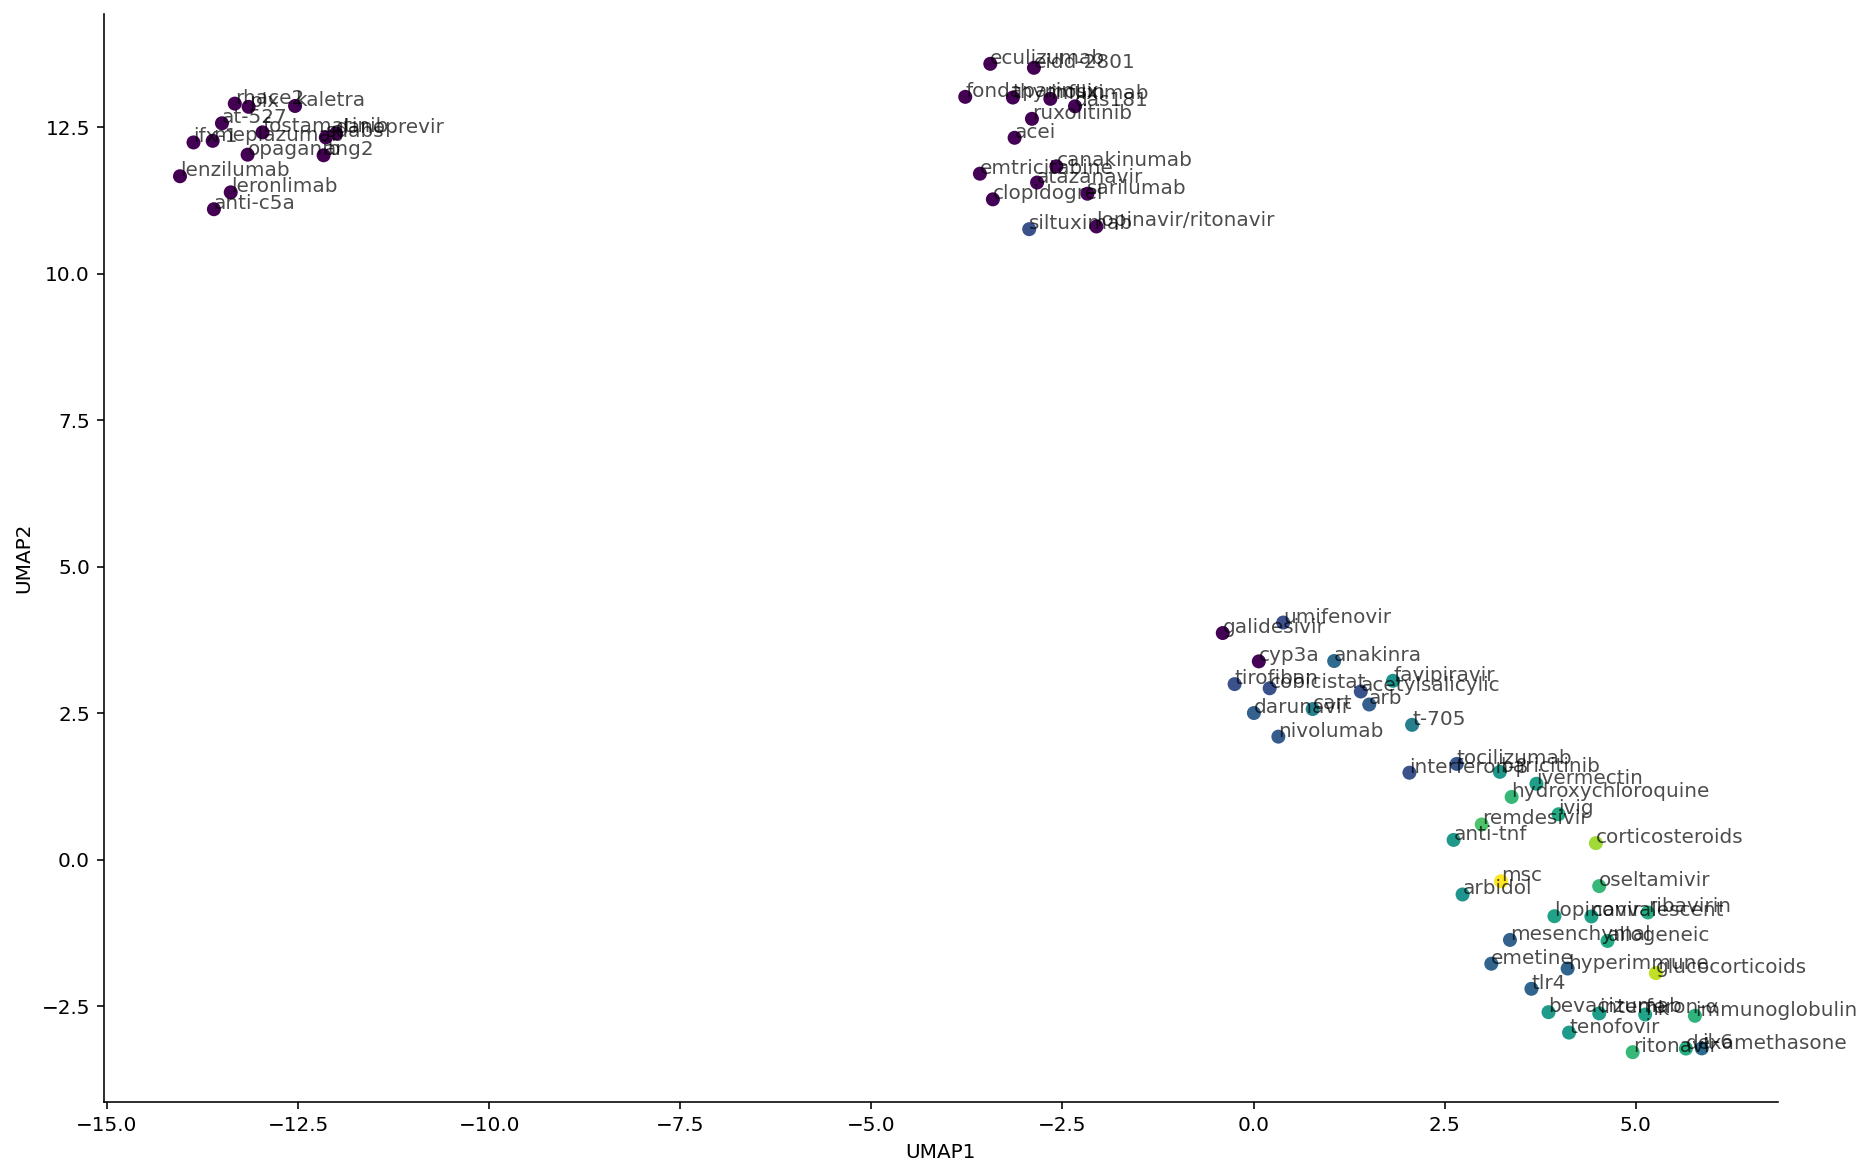

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

embed_umap = adata.obsm['X_umap']

plt.scatter(embed_umap[:, 0], embed_umap[:, 1], c=adata.obs['positive_scores'].values)

for idx in range(len(adata.obs_names)):
    plt.annotate(adata.obs_names[idx], (embed_umap[idx, 0], embed_umap[idx, 1]), alpha=0.7)

# settings
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# plt.savefig('figures/umap_positive_scores_20epoch.pdf')  

Text(0, 0.5, 'UMAP2')

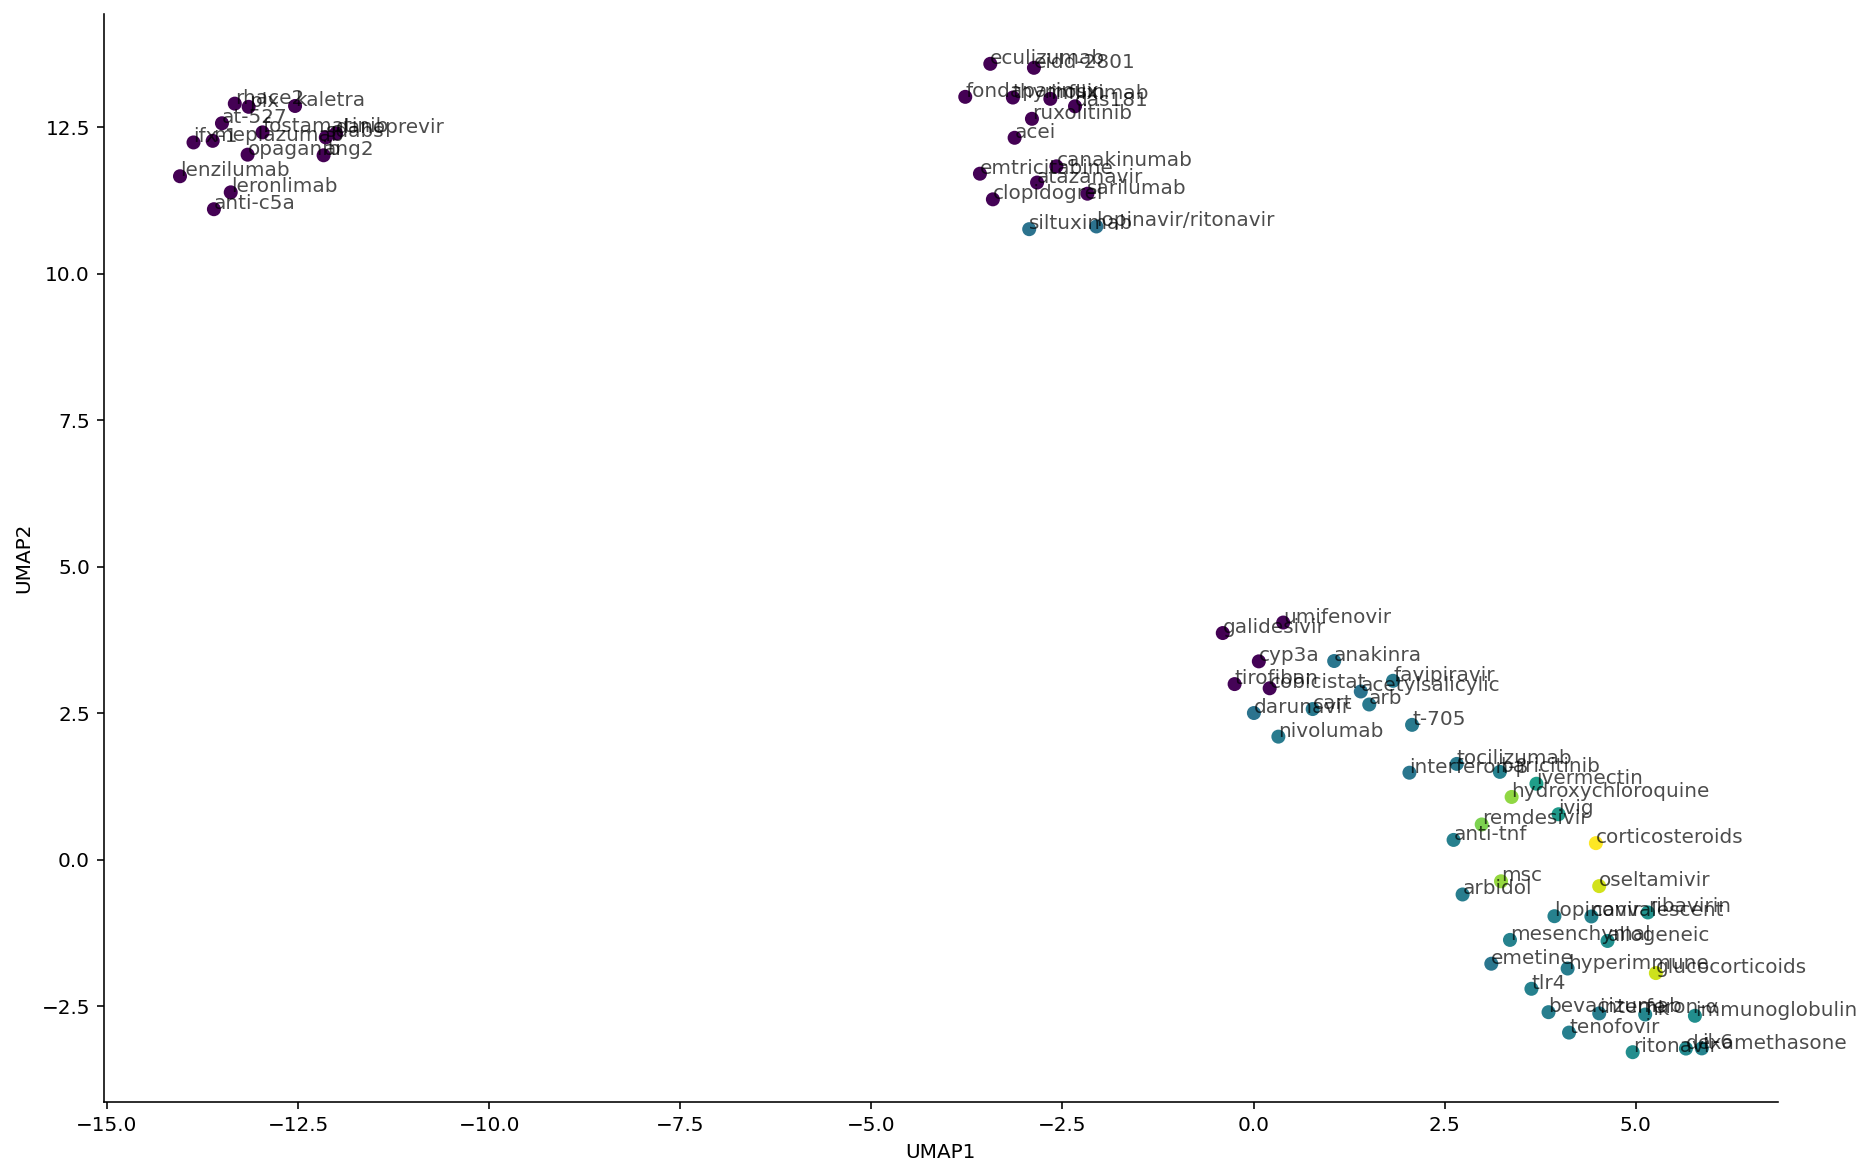

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.scatter(embed_umap[:, 0], embed_umap[:, 1], c=adata.obs['negative_scores'].values)

for idx in range(len(adata.obs_names)):
    plt.annotate(adata.obs_names[idx], (embed_umap[idx, 0], embed_umap[idx, 1]), alpha=0.7)

# settings
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# plt.savefig('figures/umap_negative_scores_20epoch.pdf')  

Text(0, 0.5, 'UMAP2')

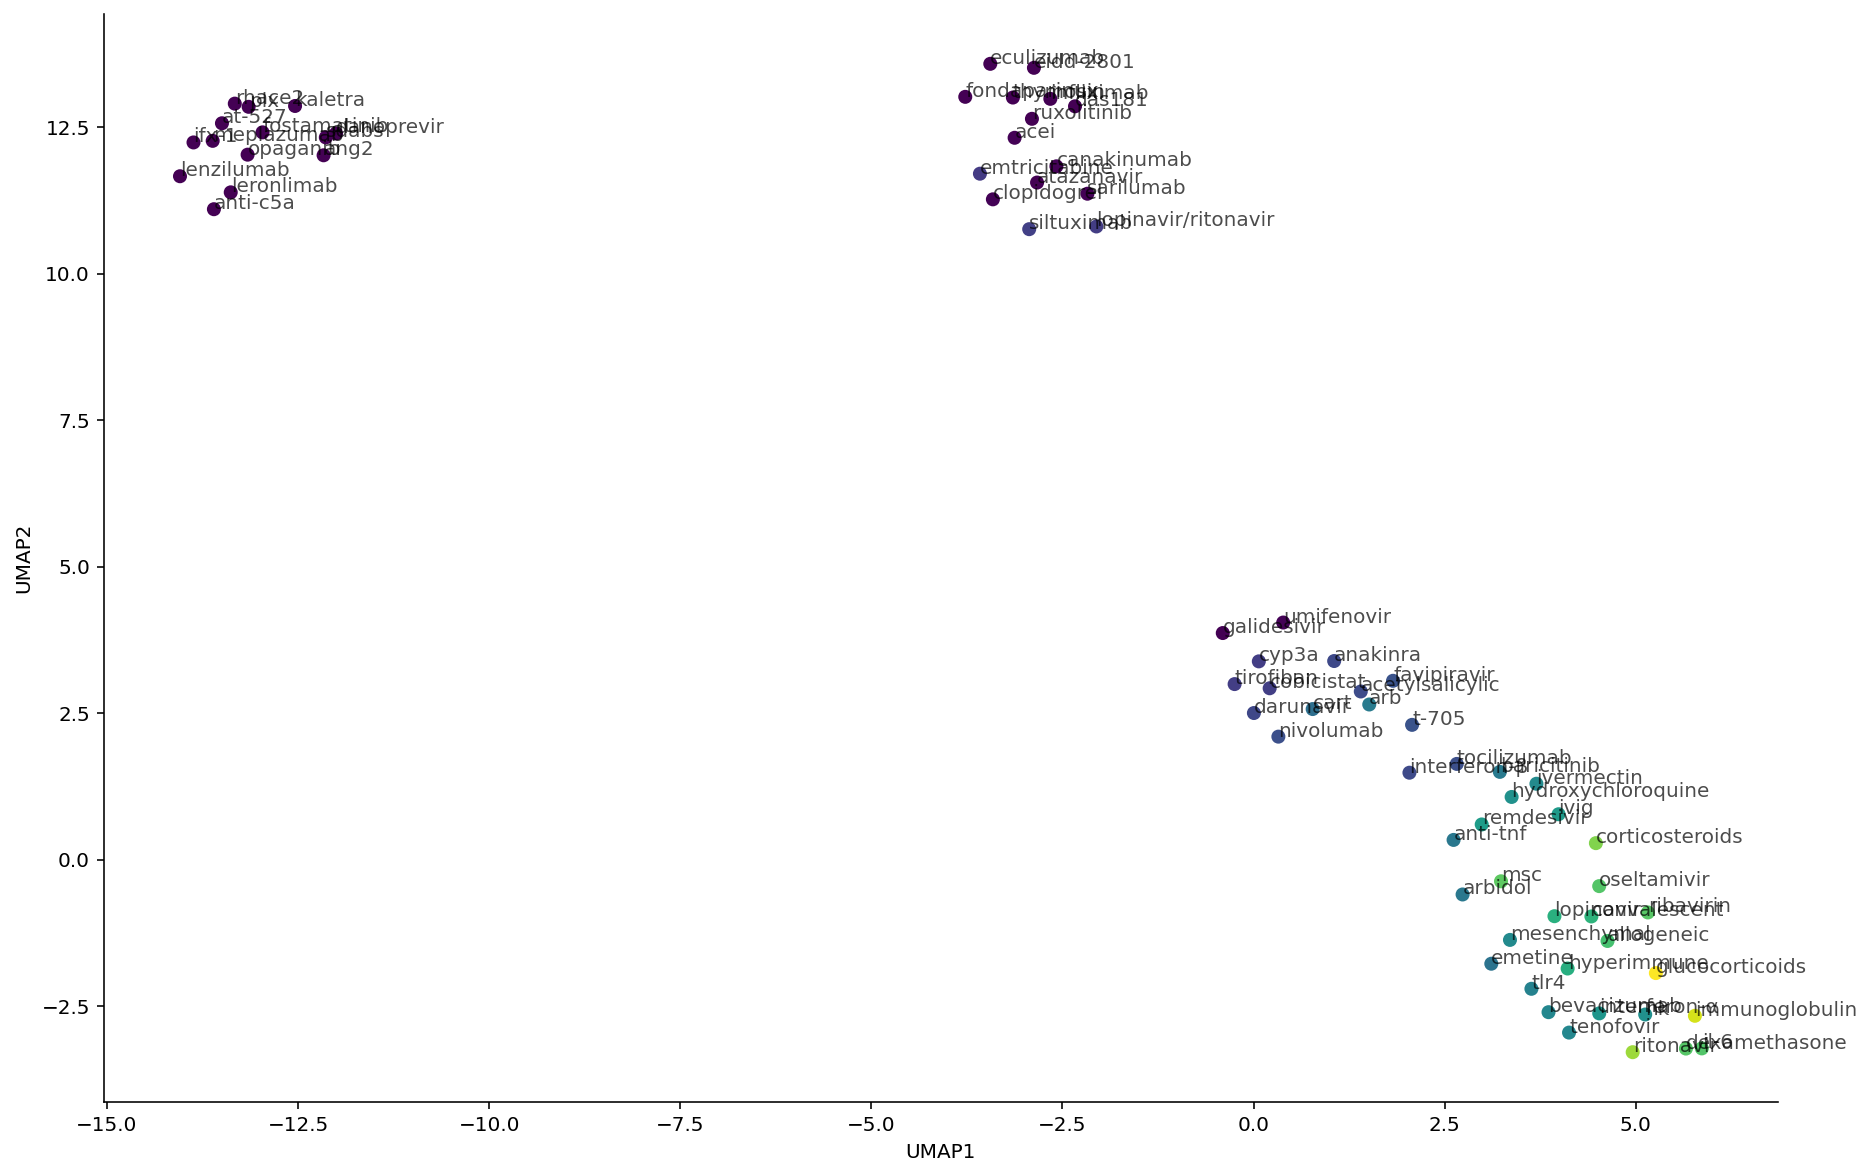

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.scatter(embed_umap[:, 0], embed_umap[:, 1], c=adata.obs['uncertainty_scores'].values)

for idx in range(len(adata.obs_names)):
    plt.annotate(adata.obs_names[idx], (embed_umap[idx, 0], embed_umap[idx, 1]), alpha=0.7)

# settings
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# plt.savefig('figures/umap_uncertainty_scores_20epoch.pdf')  

In [ ]:
# Sorting the performance scores for visualization
result_scores = adata.obs[['positive_scores', 'uncertainty_scores', 'negative_scores']]
result_scores.sort_values(by=['positive_scores', 'negative_scores', 'uncertainty_scores'], 
                          ascending=[False, True, True]) # to reorder the combinations according to user's interest
                                                                          

,positive_scores,uncertainty_scores,negative_scores
msc,0.039267,0.041769,0.020512
glucocorticoids,0.035362,0.056022,0.022713
corticosteroids,0.033317,0.044959,0.024788
remdesivir,0.027741,0.030005,0.019494
hydroxychloroquine,0.025657,0.027091,0.020288
ritonavir,0.025640,0.047437,0.010965
oseltamivir,0.025599,0.040563,0.022950
immunoglobulin,0.024746,0.052241,0.011148
dexamethasone,0.023689,0.040675,0.010643
ribavirin,0.023453,0.040992,0.011676


#### Visualizing the important features/sentimentals defining each cluster
We can identify features/sentimental terms that are differentially characterizing each cluster. Here we ranked the top 40 over-expressing sentiment terms defining a cluster.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning:

invalid value encountered in log2



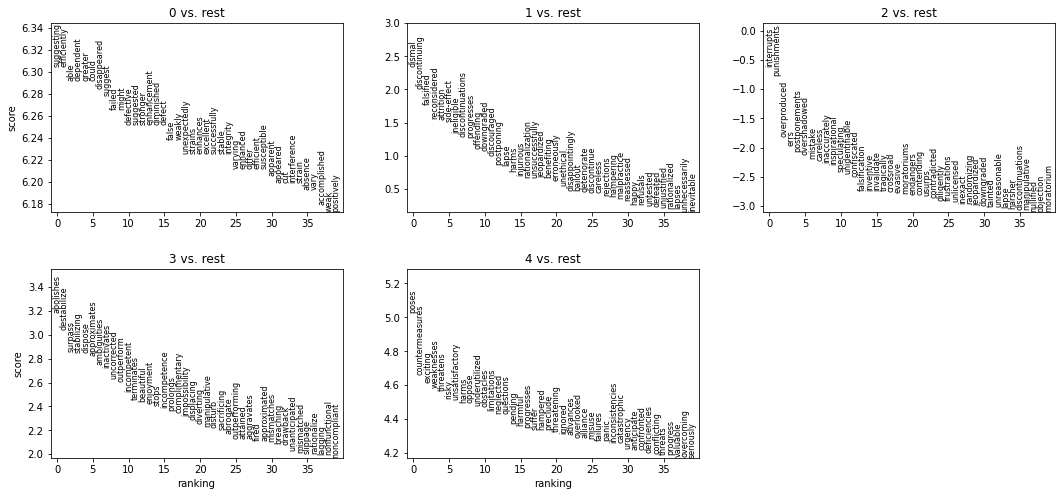

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=40, sharey=False, ncols=3)

Both heatmap and matrixplot show that the top 10 differential sentiments in Cluster 0 were mostly positive sentiments, while the top 10 differential sentiments in Cluster 4 were mostly negative sentiments. 

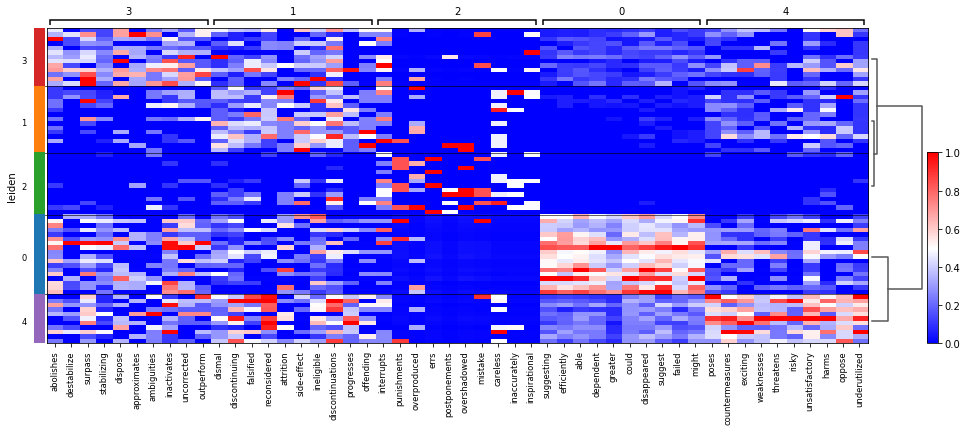

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, use_raw=True, 
                                  cmap='bwr', standard_scale='var', save='heatmap_differential_sentiments.pdf')

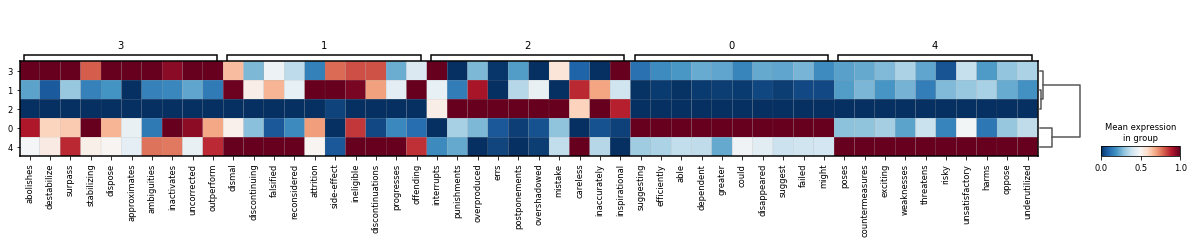

In [ ]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=10, use_raw=True, 
                                      cmap='RdBu_r', standard_scale='var', save='matrixplot_differential_sentiments.pdf');

Lastly, we facet the TAs in interactive html, with Binnings of X-Axis and Y-Axis set to negative and positive scores. The dotted TAs are colored with uncertainty scores. The top performer was MSC (Mesenchymal stem cells) treatment, the bottom performer was the lopinavir/ritonavir, which was currently not recommended by the NIH for COVID-19 treatment.

In [ ]:
# Display the Dive visualization for the training data.
from IPython.core.display import display, HTML

jsonstr = adata.obs[['positive_scores', 'negative_scores', 'uncertainty_scores']].reset_index(drop=False).to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""

html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

In [ ]:
# saving HTML(html)
with open('figures/drug_efficiency_facets.html', 'w') as f:
    f.write(html)


### 13. Author's final thoughts
The project may facilitate literature research in MOA and relative rankings of the TAs and relevant strategic plannings. A more real-time tracking of the results will be useful in the current fast-moving period, where multiple concurrent researches and clinical trials focusing on the COVID-19 are conducted world-wide. Monitoring of both qualitative and quantitative growth of textual data objectively and making strategic decisions based on how situations, as depicted in the scientific reports, evolve, is important for many researchers/stakeholders.

However, it is recommended to improve robustness of the conclusions through inclusion of more analytic projects and involvement of more domain experts. 
